# Helmet Detection

## importing tf and checking gpu availability

In [1]:
# creating folders to upload data
!mkdir -p Helmet/train/images Helmet/test/images Helmet/train/labels Helmet/test/labels

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7748599098281203546
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18037197620402139537
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Labeling

In [ ]:
## datas are labeld using labelme

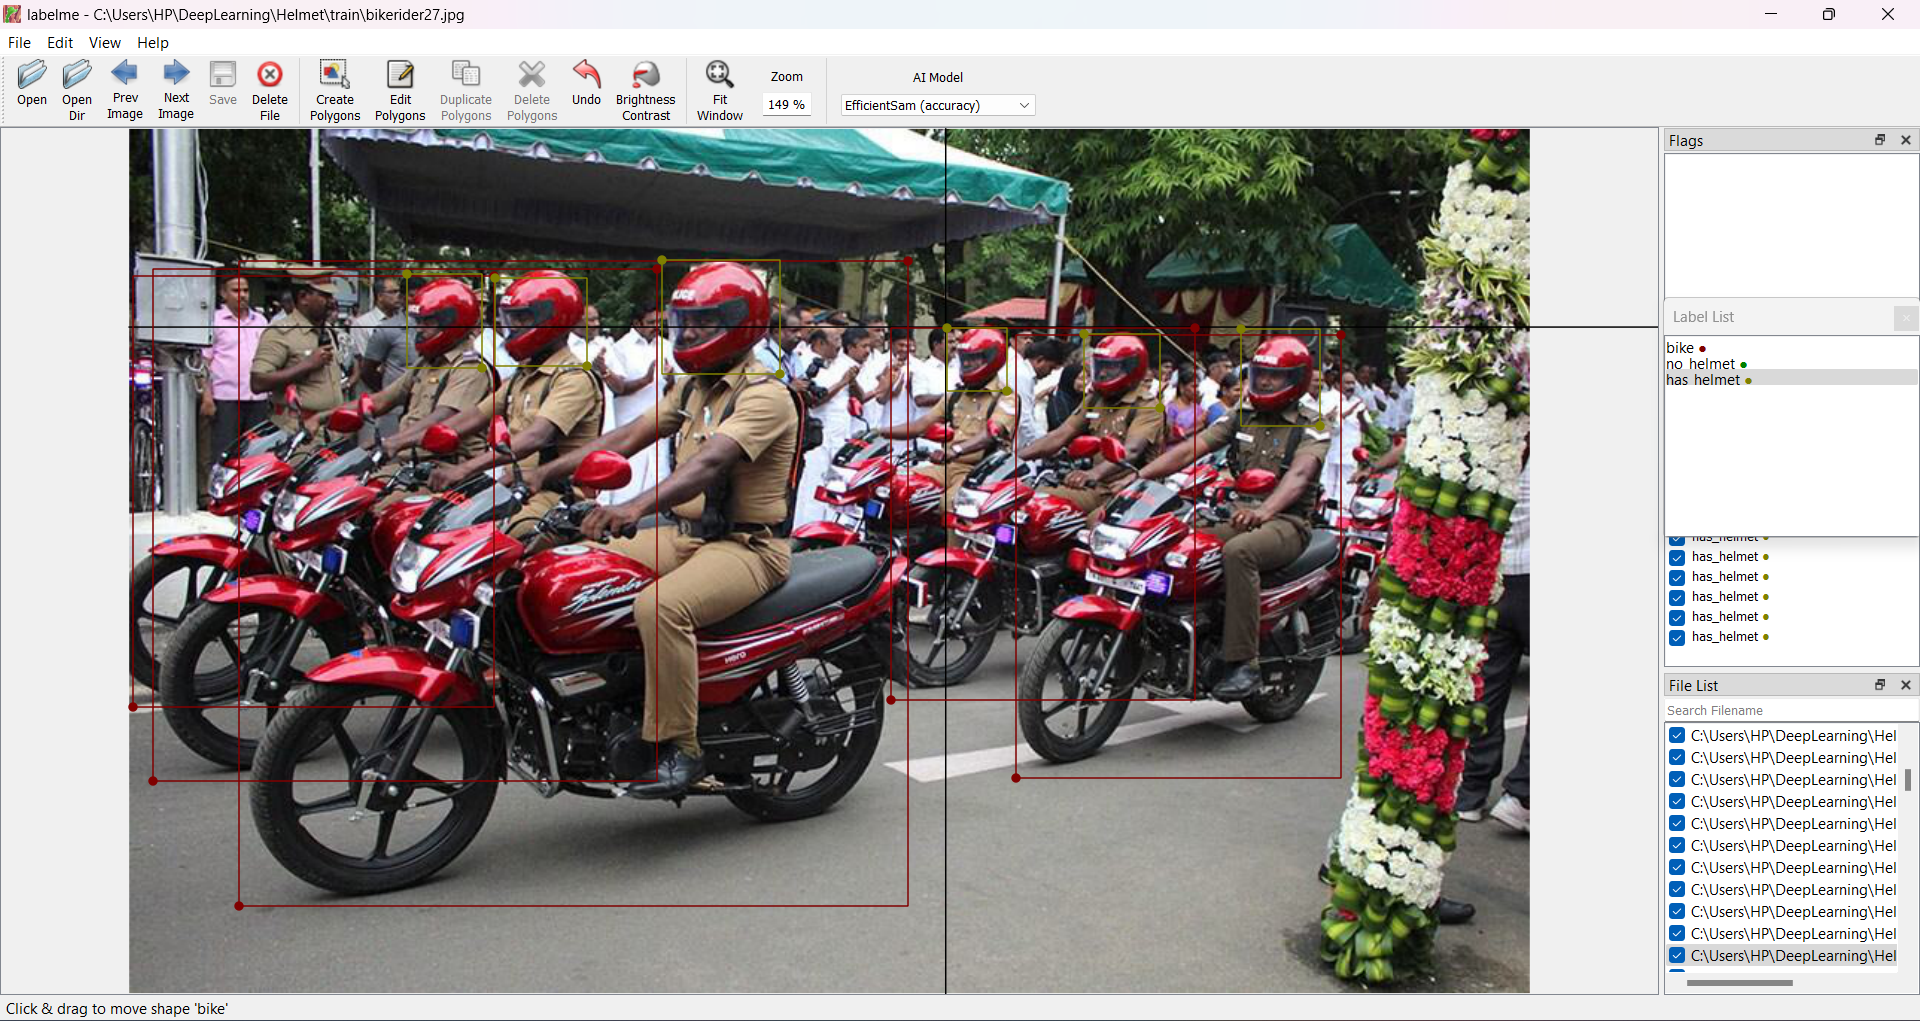

### Import libraries

In [40]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

In [5]:
train = tf.data.Dataset.list_files('Helmet/train/images/*.jpg')

def resize_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.resize(image, (300, 300))
  image = image / 255.0
  return image

train = train.map(resize_image)


In [6]:
train.as_numpy_iterator().next()

array([[[0.24598692, 0.21853594, 0.1871634 ],
        [0.24142222, 0.21397124, 0.1825987 ],
        [0.24170806, 0.21425708, 0.18288453],
        ...,
        [0.38253596, 0.30802616, 0.3158693 ],
        [0.40107188, 0.33048365, 0.33048365],
        [0.40107188, 0.33048365, 0.33048365]],

       [[0.23992157, 0.21247059, 0.18109804],
        [0.23364706, 0.20619608, 0.17482354],
        [0.23469281, 0.20724183, 0.17586929],
        ...,
        [0.39466667, 0.3298039 , 0.33443138],
        [0.40392157, 0.3397647 , 0.34298038],
        [0.40392157, 0.3397647 , 0.3397647 ]],

       [[0.24325055, 0.21579957, 0.18442701],
        [0.23830065, 0.21084967, 0.17947713],
        [0.2393464 , 0.21189542, 0.18052287],
        ...,
        [0.4115468 , 0.3502396 , 0.357037  ],
        [0.40784314, 0.34797385, 0.35045752],
        [0.40784314, 0.34797385, 0.34797385]],

       ...,

       [[0.8173856 , 0.6918954 , 0.5988235 ],
        [0.82577777, 0.7002876 , 0.60721564],
        [0.81655777, 0

In [7]:
type(train)

tensorflow.python.data.ops.map_op._MapDataset

### View Raw Images with Matplotlib

In [8]:
image_generator = train.batch(8).as_numpy_iterator()

In [9]:
plot_images = image_generator.next()

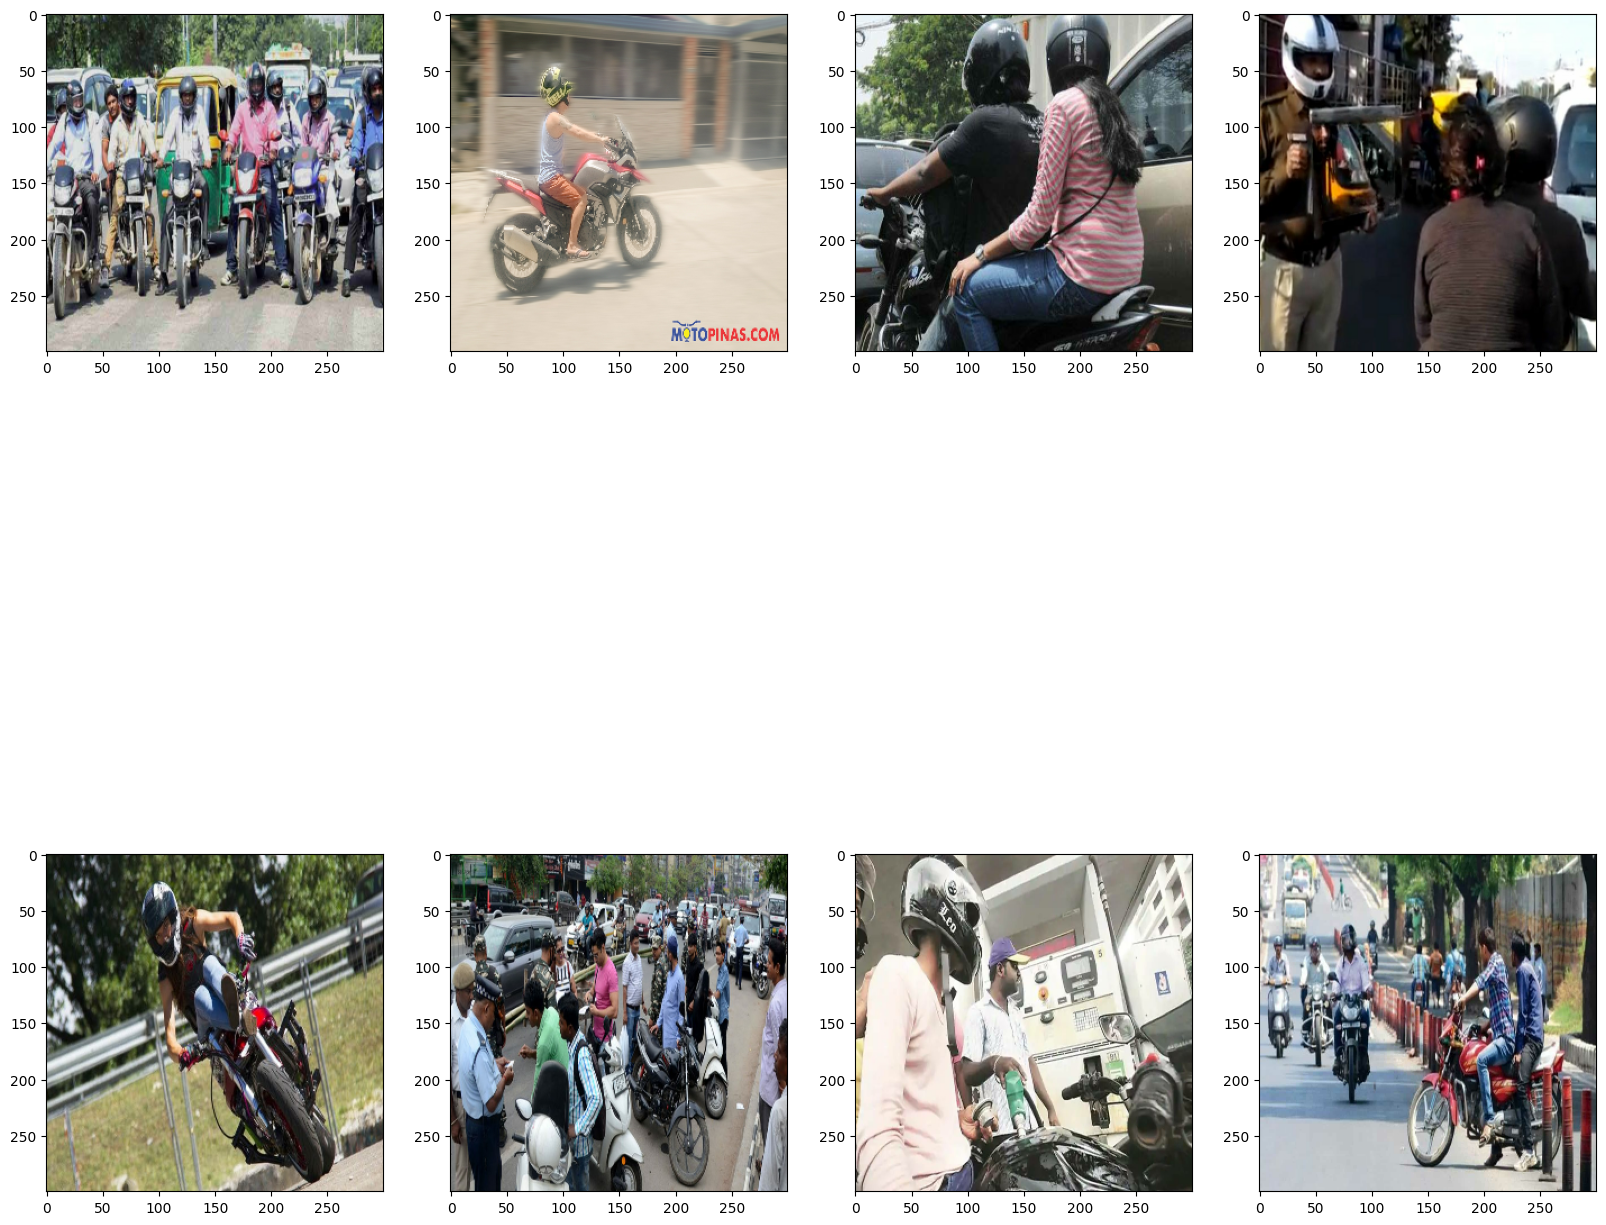

In [10]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 20))
for row_idx in range(2):
    for col_idx in range(4):
        ax[row_idx, col_idx].imshow(plot_images[row_idx * 4 + col_idx])
plt.show()

## Apply Image Augmentation on Images and Labels using Albumentations

In [12]:
import json

with open('/content/Helmet/train/labels/bikerider0.json',) as f:
   test = json.load(f)

In [17]:
type(test)

dict

dict

In [18]:
test.keys()

dict_keys(['version', 'flags', 'shapes', 'imagePath', 'imageData', 'imageHeight', 'imageWidth'])

In [19]:
test['shapes']

[{'label': 'bike',
  'points': [[346.3503649635037, 19.839416058394164],
   [733.9416058394161, 624.948905109489]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None},
 {'label': 'bike',
  'points': [[173.3576642335767, 26.408759124087595],
   [408.39416058394164, 493.5620437956204]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None},
 {'label': 'bike',
  'points': [[747.8102189781022, 33.70802919708029],
   [881.3868613138686, 313.2700729927007]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None},
 {'label': 'bike',
  'points': [[955.8394160583941, 2.3211678832116838],
   [1198.8511579916774, 627.0]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None},
 {'label': 'no_helmet',
  'points': [[564.5985401459855, 173.12408759124088],
   [468.97810218978105, 29.328467153284674]],
  'group_id'

In [20]:
type(test['shapes'])

list

In [21]:
shape = test['shapes']

In [22]:
len(shape)

10

In [31]:
coords = {}
bikelist = []
nh_list = []
hh_list = []
for item in shape:
    if item['label'] == 'bike':
      coord =[0,0,0,0]
      coord[0] = item['points'][0][0]
      coord[1] = item['points'][0][1]
      coord[2] = item['points'][1][0]
      coord[3] = item['points'][1][1]
      bikelist.append(coord)
    elif item['label'] == 'no_helmet':
      coord =[0,0,0,0]
      coord[0] = item['points'][0][0]
      coord[1] = item['points'][0][1]
      coord[2] = item['points'][1][0]
      coord[3] = item['points'][1][1]
      nh_list.append(coord)
    elif item['label'] == 'has_helmet':
      coord =[0,0,0,0]
      coord[0] = item['points'][0][0]
      coord[1] = item['points'][0][1]
      coord[2] = item['points'][1][0]
      coord[3] = item['points'][1][1]
      hh_list.append(coord)

In [32]:
bikelist

[[346.3503649635037, 19.839416058394164, 733.9416058394161, 624.948905109489],
 [173.3576642335767,
  26.408759124087595,
  408.39416058394164,
  493.5620437956204],
 [747.8102189781022, 33.70802919708029, 881.3868613138686, 313.2700729927007],
 [955.8394160583941, 2.3211678832116838, 1198.8511579916774, 627.0]]

In [33]:
nh_list

[[564.5985401459855,
  173.12408759124088,
  468.97810218978105,
  29.328467153284674],
 [411.31386861313877,
  22.029197080291972,
  508.3941605839417,
  145.38686131386862],
 [250.00000000000009,
  36.627737226277375,
  316.42335766423366,
  119.83941605839416],
 [584.3065693430657,
  55.605839416058394,
  621.5328467153286,
  103.78102189781022]]

In [34]:
hh_list

[[843.4306569343066, 97.21167883211679, 794.5255474452555, 40.277372262773724],
 [1197.4452554744526,
  127.86861313868613,
  1080.6569343065694,
  3.781021897810224]]

In [36]:
#Apply Augmentations and View Results

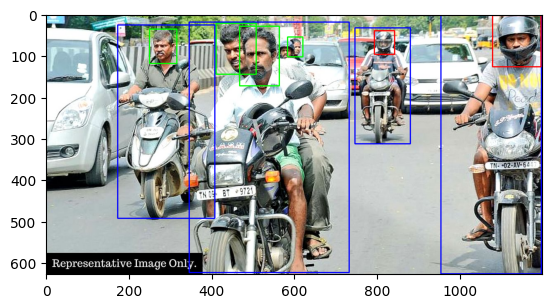

In [44]:
# Color map for different labels
color_map = {
    'bike': (255, 0, 0),       # Red for bike
    'no_helmet': (0, 255, 0),  # Green for no_helmet
    'has_helmet': (0, 0, 255)  # Blue for has_helmet
}

for label, coords in [('bike', bikelist), ('no_helmet', nh_list), ('has_helmet', hh_list)]:
    for bbox in coords:
        cv2.rectangle(img,
                      (int(bbox[0]), int(bbox[1])),
                      (int(bbox[2]), int(bbox[3])),
                      color_map[label], 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
